# STATS 231A Homework 2 - Candace McKeag

# Env Setup

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import gzip
import pickle
from tqdm import tqdm
import math

# Problem 1

https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1

Read the above blog on CNN (ConvNet).

## (1)

Write a detailed annotation of the code, i.e., go over some important lines, and explain what they are doing.

In [2]:
# Step 1: Getting the data
def extract_data(filename, num_images, image_width):
    """
    Extract images by reading the file bytestream. Reshape the read values into a 3D matrix of dimensions [m, h, w],
    where m is the number of training examples.

    Parameters
    ----------
    filename : str
        name of the .gz file containing the data
    num_images : int
        number of images to read from the file
    image_width : int
        pixel width of images to read

    Returns
    -------
    data : np.ndarray
        num_images x image_width*image_width numpy array containing pixel data
    """
    print('Extracting', filename)
    # access the bytestream of the tensors
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        # create buffer from bytestream
        buf = bytestream.read(image_width * image_width * num_images)
        # convert buffer into 1D numpy array
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        # reshape array into (num_images, image_width*image_width) shape array
        data = data.reshape(num_images, image_width * image_width)
        return data


def extract_labels(filename, num_images):
    """
    Extract label into vector of integer values of dimensions [m, 1], where m is the number of images.

    Parameters
    ----------
    filename : str
        name of the .gz file containing the labels
    num_images : int
        number of labels to read from the file

    Returns
    -------
    labels : np.ndarray
        1D numpy array containing corresponding image labels
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        # create labels buffer from bytestream
        buf = bytestream.read(1 * num_images)
        # convert buffer into 1D numpy array of labels
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [3]:
# Step 2: Initialize parameters
def initialize_filter(size, scale=1.0):
    """
    Initialize the filters for the convolutional layers using a normal distribution with a
    standard deviation inversely proportional to the square root of the number of units.
    Using the standard normal distribution makes for a smoother training process.

    Parameters
    ----------
    size : Tuple[int, int, int, int]
        number of units
    scale : float
        scale, default=1.0

    Returns
    -------
    (size) random normal RVs with mean 0 and scale (scale/np.sqrt(np.prod(size)))
    """
    # create stddev inverse prop to sqrt(number of units)
    stddev = scale / np.sqrt(np.prod(size))
    # return a normal RV with mean 0 and using stddev
    return np.random.normal(loc=0, scale=stddev, size=size)


def initialize_weight(size):
    """
    Initialize the weights for the dense layers with a random normal distribution.

    Parameters
    ----------
    size : Tuple[int, int]
        number of units

    Returns
    -------
    (size) standard normal RVs * 0.01
    """
    # output a standard normal RV * 0.01.
    return np.random.standard_normal(size=size) * 0.01

In [4]:
# Step 3: Define the backpropagation operations
def convolution_backward(dconv_prev, conv_in, filt, s):
    """
    Backpropagation of gradients through a convolutional layer.

    Parameters
    ----------
    dconv_prev : np.ndarray
        previous convolutional layer gradient
    conv_in : np.ndarray
        convolutional layer input
    filt : np.ndarray
        filter
    s : int
        stride

    Returns
    -------
    dout : np.ndarray
        loss gradient of the input to the convolutional operation
    dfilt : np.ndarray
        loss gradient of filter, used to update hte filter
    dbias : np.ndarray
        loss gradient of the bias
    """
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    # initialize derivatives
    dout = np.zeros(conv_in.shape)
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f, 1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y + f, curr_x:curr_x + f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y + f, curr_x:curr_x + f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])

    return dout, dfilt, dbias


def nanargmax(arr):
    """
    return index of the largest non-nan value in the array. Output is an ordered pair tuple

    Parameters
    ----------
    arr : np.ndarray
        array to find largest non-nan value from

    Returns
    -------
    idxs : tuple of np.ndarray
        an ordered pair tuple containing index of the largest non-nan value
    """
    idx = np.nanargmax(arr)
    # converts flat array idx into a tuple of coordinate arrays
    idxs = np.unravel_index(idx, arr.shape)
    return idxs


def maxpool_backward(dpool, orig, f, s):
    """
    Backpropagation through a maxpooling layer. The gradients are passed through the
    indices of greatest value in the original maxpooling during the forward step.

    Parameters
    ----------
    dpool : np.ndarray
        max-pooling layer gradient
    orig : np.ndarray
        previous maxpooling layer
    f : int
        kernel size
    s : int
        stride

    Returns
    -------
    dout : np.ndarray
        loss gradient of the input to the convolutional operation
    """
    (n_c, orig_dim, _) = orig.shape

    # initialize loss gradient
    dout = np.zeros(orig.shape)

    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y + f, curr_x:curr_x + f])
                # pass gradients through
                dout[curr_c, curr_y + a, curr_x + b] = dpool[curr_c, out_y, out_x]

                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1

    return dout

In [5]:
# Step 3.5: Define the forward operations
def convolution(image, filt, bias, s=1):
    """
    Convolves the filter over every part of the image, adding the bias at each step.

    Parameters
    ----------
    image : np.ndarray
        images
    filt : np.ndarray
        filter
    bias : np.ndarray
        bias
    s : int
        stride, default=1

    Returns
    -------
    out : np.ndarray
        convolutional layer
    """
    (n_f, n_c_f, f, _) = filt.shape  # filter dimensions
    n_c, in_dim, _ = image.shape  # image dimensions

    out_dim = int((in_dim - f) / s) + 1  # calculate output dimensions

    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"

    out = np.zeros((n_f, out_dim, out_dim))

    # convolve the filter over every part of the image, adding the bias at each step.
    for curr_f in range(n_f):
        # initialize current and output y
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            # initialize current and output x
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                # convolution
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:, curr_y:curr_y + f, curr_x:curr_x + f]) + \
                                            bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1

    return out


def maxpool(image, f=2, s=2):
    """
    Downsample `image` using kernel size `f` and stride `s`. Slides maxpool window over each part of the
    image and assigns the max value at each step to the output.

    Parameters
    ----------
    image : np.ndarray
        image to downsample
    f : int
        kernel size, default=2
    s : int
        stride, default=2

    Returns
    -------
    downsampled : np.ndarray
        downsampled image
    """
    n_c, h_prev, w_prev = image.shape

    h = int((h_prev - f) / s) + 1
    w = int((w_prev - f) / s) + 1

    # initialize downsampled image values
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                # assign max value to output
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y + f, curr_x:curr_x + f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled


def softmax(x):
    """
    performs softmax activation

    Parameters
    ----------
    x : np.ndarray
        array to perform softmax activation on

    Returns
    -------
    out / np.sum(out) : np.ndarray
        softmax activated x
    """
    out = np.exp(x)
    return out / np.sum(out)


def categorical_cross_entropy(probs, label):
    """
    Performs categorical cross-entropy

    Parameters
    ----------
    probs : np.ndarray
        array of predicted probabilities
    label : np.ndarray
        array of true labels

    Returns
    -------
    -np.sum(label * np.log(probs)) : float
        categorical cross entropy of probs and label
    """
    return -np.sum(label * np.log(probs))

In [6]:
# Step 4: Building the network
def conv(image, label, params, conv_s, pool_f, pool_s):
    """
    Combines the forward and backward operations to build the network. Takes the network's parameters and
    hyperparameters as inputs and spits out the gradients.

    Parameters
    ----------
    image : np.ndarray
        images to build network
    label : np.ndarray
        labels corresponding to images
    params : list
        network's parameters
    conv_s : int
        convolutional layer stride
    pool_f : int
        pooling layer kernel size
    pool_s : int
        pooling layer stride

    Returns
    -------
    grads : list
        gradients
    loss : float
        categorical cross-entropy loss
    """

    # set parameters
    [f1, f2, w3, w4, b1, b2, b3, b4] = params

    ################################################
    # Forward Operation #
    ################################################
    conv1 = convolution(image, f1, b1, conv_s)  # convolution operation
    conv1[conv1 <= 0] = 0  # pass through ReLU non-linearity

    conv2 = convolution(conv1, f2, b2, conv_s)  # second convolution operation
    conv2[conv2 <= 0] = 0  # pass through ReLU non-linearity

    pooled = maxpool(conv2, pool_f, pool_s)  # maxpooling operation

    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1))  # flatten pooled layer

    z = w3.dot(fc) + b3  # first dense layer
    z[z <= 0] = 0  # pass through ReLU non-linearity

    out = w4.dot(z) + b4  # second dense layer

    probs = softmax(out)  # predict class probabilities with the softmax activation function

    ################################################
    # Loss #
    ################################################

    loss = categorical_cross_entropy(probs, label)  # categorical cross-entropy loss

    ################################################
    # Backward Operation #
    ################################################
    dout = probs - label  # derivative of loss w.r.t. final dense layer output
    dw4 = dout.dot(z.T)  # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis=1).reshape(b4.shape)  # loss gradient of final dense layer biases

    dz = w4.T.dot(dout)  # loss gradient of first dense layer outputs
    dz[z <= 0] = 0  # backpropagate through ReLU
    dw3 = dz.dot(fc.T)
    db3 = np.sum(dz, axis=1).reshape(b3.shape)

    dfc = w3.T.dot(dz)  # loss gradients of fully-connected layer (pooling layer)
    dpool = dfc.reshape(pooled.shape)  # reshape fully connected into dimensions of pooling layer

    # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2 = maxpool_backward(dpool, conv2, pool_f, pool_s)
    dconv2[conv2 <= 0] = 0  # backpropagate through ReLU

    # backpropagate previous gradient through second convolutional layer.
    dconv1, df2, db2 = convolution_backward(dconv2, conv1, f2, conv_s)
    dconv1[conv1 <= 0] = 0  # backpropagate through ReLU

    # backpropagate previous gradient through first convolutional layer.
    dimage, df1, db1 = convolution_backward(dconv1, image, f1, conv_s)

    grads = [df1, df2, dw3, dw4, db1, db2, db3, db4]

    return grads, loss

In [7]:
# Step 5: Training the network
def adam_gd(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost):
    """
    Update the parameters through Adam gradient descent. Forces the network's parameters to learn
    meaningful representations.

    Parameters
    ----------
    batch : np.ndarray
        batch of images to input
    num_classes : int
        number of classes in labels
    lr : float
        learning rate
    dim : int
        dimension
    n_c : int
        first dim of image shape
    beta1 : float
        weight to update momentum
    beta2 : float
        weight to update RMSProp
    params : list
        network parameters
    cost : list
        cost

    Returns
    -------
    params : list
        network parameters
    cost : list
        cost, summation of loss
    """
    [f1, f2, w3, w4, b1, b2, b3, b4] = params

    x = batch[:, 0:-1]  # get batch inputs
    x = x.reshape(len(batch), n_c, dim, dim)
    y = batch[:, -1]  # get batch labels

    cost_ = 0
    batch_size = len(batch)

    # initialize gradients and momentum, RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)

    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)

    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)

    for i in range(batch_size):
        # image for this batch
        c = x[i]
        # one-hot encoded label
        lbl = np.eye(num_classes)[int(y[i])].reshape(num_classes, 1)  # convert label to one-hot

        # collect gradients for training example
        grads, loss = conv(c, lbl, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads

        df1 += df1_
        db1 += db1_
        df2 += df2_
        db2 += db2_
        dw3 += dw3_
        db3 += db3_
        dw4 += dw4_
        db4 += db4_

        cost_ += loss

    # Parameter Update

    v1 = beta1 * v1 + (1 - beta1) * df1 / batch_size  # momentum update
    s1 = beta2 * s1 + (1 - beta2) * (df1 / batch_size) ** 2  # RMSProp update
    f1 -= lr * v1 / np.sqrt(s1 + 1e-7)  # combine momentum and RMSProp to perform update with Adam

    bv1 = beta1 * bv1 + (1 - beta1) * db1 / batch_size
    bs1 = beta2 * bs1 + (1 - beta2) * (db1 / batch_size) ** 2
    b1 -= lr * bv1 / np.sqrt(bs1 + 1e-7)

    v2 = beta1 * v2 + (1 - beta1) * df2 / batch_size
    s2 = beta2 * s2 + (1 - beta2) * (df2 / batch_size) ** 2
    f2 -= lr * v2 / np.sqrt(s2 + 1e-7)

    bv2 = beta1 * bv2 + (1 - beta1) * db2 / batch_size
    bs2 = beta2 * bs2 + (1 - beta2) * (db2 / batch_size) ** 2
    b2 -= lr * bv2 / np.sqrt(bs2 + 1e-7)

    v3 = beta1 * v3 + (1 - beta1) * dw3 / batch_size
    s3 = beta2 * s3 + (1 - beta2) * (dw3 / batch_size) ** 2
    w3 -= lr * v3 / np.sqrt(s3 + 1e-7)

    bv3 = beta1 * bv3 + (1 - beta1) * db3 / batch_size
    bs3 = beta2 * bs3 + (1 - beta2) * (db3 / batch_size) ** 2
    b3 -= lr * bv3 / np.sqrt(bs3 + 1e-7)

    v4 = beta1 * v4 + (1 - beta1) * dw4 / batch_size
    s4 = beta2 * s4 + (1 - beta2) * (dw4 / batch_size) ** 2
    w4 -= lr * v4 / np.sqrt(s4 + 1e-7)

    bv4 = beta1 * bv4 + (1 - beta1) * db4 / batch_size
    bs4 = beta2 * bs4 + (1 - beta2) * (db4 / batch_size) ** 2
    b4 -= lr * bv4 / np.sqrt(bs4 + 1e-7)

    cost_ = cost_ / batch_size
    cost.append(cost_)

    params = [f1, f2, w3, w4, b1, b2, b3, b4]

    return params, cost


def train(num_classes=10, lr=0.01, beta1=0.95, beta2=0.99, img_dim=28, img_depth=1, f=5,
          num_filt1=8, num_filt2=8, batch_size=32, num_epochs=2, save_path='params.pkl'):
    """
    Trains the network. Gets training data, initializes parameters,

    Parameters
    ----------
    num_classes : int
        number of classes in labels
    lr : float
        learning rate
    beta1 : float
        weight to update momentum
    beta2 : float
        weight to update RMSprop
    img_dim : int
        image dimension
    img_depth : int
        image depth
    f : int
        kernel size
    num_filt1 : int
        number of filters
    num_filt2 : int
        number of filters
    batch_size : int
        size of batch to train on
    num_epochs : int
        number of training epochs
    save_path : str
        name of path to save network parameters

    Returns
    -------
    cost : list
        sum of loss from training
    """

    # Get training data
    m = 50000
    x = extract_data('train-images-idx3-ubyte.gz', m, img_dim)
    y_dash = extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m, 1)
    x -= int(np.mean(x))
    x /= int(np.std(x))
    train_data = np.hstack((x, y_dash))

    np.random.shuffle(train_data)

    # Initializing all the parameters
    f1, f2, w3, w4 = (num_filt1, img_depth, f, f), (num_filt2, num_filt1, f, f), (128, 800), (10, 128)
    f1 = initialize_filter(f1)
    f2 = initialize_filter(f2)
    w3 = initialize_weight(w3)
    w4 = initialize_weight(w4)

    b1 = np.zeros((f1.shape[0], 1))
    b2 = np.zeros((f2.shape[0], 1))
    b3 = np.zeros((w3.shape[0], 1))
    b4 = np.zeros((w4.shape[0], 1))

    params = [f1, f2, w3, w4, b1, b2, b3, b4]

    cost = []

    print("LR:" + str(lr) + ", Batch Size:" + str(batch_size))

    for epoch in range(num_epochs):
        # shuffle training data
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        t = tqdm(batches)
        for c, batch in enumerate(t):
            # perform AdamGD
            params, cost = adam_gd(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
            t.set_description("Cost: %.2f" % (cost[-1]))

    # save parameters in local path
    with open(save_path, 'wb') as file:
        pickle.dump(params, file)

    return cost

Training using the original parameters takes up to 5 hours. We truncate the training data to only 1,000 images, use a batch size of 16, and only one epoch to decrease the training time.

In [8]:
cost_1 = train(m=1000, batch_size=32, num_epochs=1)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32
Cost: 2.30 , Batch Num: 1
Cost: 2.30 , Batch Num: 2
Cost: 2.30 , Batch Num: 3
Cost: 2.30 , Batch Num: 4
Cost: 2.29 , Batch Num: 5
Cost: 2.28 , Batch Num: 6
Cost: 2.20 , Batch Num: 7
Cost: 2.17 , Batch Num: 8
Cost: 2.13 , Batch Num: 9
Cost: 2.02 , Batch Num: 10
Cost: 1.94 , Batch Num: 11
Cost: 1.95 , Batch Num: 12
Cost: 2.21 , Batch Num: 13
Cost: 1.81 , Batch Num: 14
Cost: 1.36 , Batch Num: 15
Cost: 1.46 , Batch Num: 16
Cost: 0.97 , Batch Num: 17
Cost: 1.24 , Batch Num: 18
Cost: 1.85 , Batch Num: 19
Cost: 1.03 , Batch Num: 20
Cost: 1.36 , Batch Num: 21
Cost: 1.28 , Batch Num: 22
Cost: 0.92 , Batch Num: 23
Cost: 0.97 , Batch Num: 24
Cost: 1.40 , Batch Num: 25
Cost: 1.06 , Batch Num: 26
Cost: 0.85 , Batch Num: 27
Cost: 0.86 , Batch Num: 28
Cost: 0.68 , Batch Num: 29
Cost: 0.94 , Batch Num: 30
Cost: 0.99 , Batch Num: 31
Cost: 0.31 , Batch Num: 32


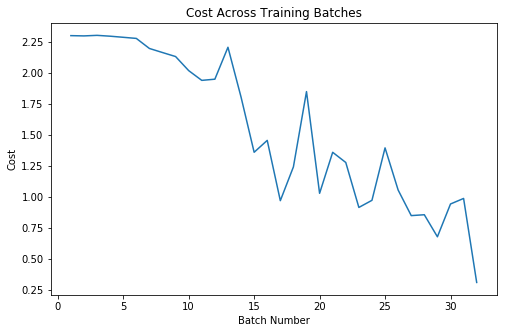

In [9]:
plt.figure(figsize=(8,5))
plt.plot(list(range(1,33)), cost_1)
plt.xlabel('Batch Number')
plt.ylabel('Cost')
plt.title('Cost Across Training Batches')
plt.show()

The original results achieve an ending cost value of about 0.31 after 32 batches. There is a decent amounut of variation in the decreasing cost value across batches.

## (2)

Change the sizes of some filters, and show results.

We can use the `num_filt1` parameter in the `train()` function to change the size of the filter. This parameter is used to initialize the filter used in the first convolutional layer. In the original code, the default value for this parameter is 8. We experiment with decreasing and increasing this filter size.

### Decrease filter size

In [10]:
cost_2a = train(m=1000, batch_size=32, num_epochs=1, num_filt1=2)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32
Cost: 2.30 , Batch Num: 1
Cost: 2.30 , Batch Num: 2
Cost: 2.30 , Batch Num: 3
Cost: 2.30 , Batch Num: 4
Cost: 2.29 , Batch Num: 5
Cost: 2.25 , Batch Num: 6
Cost: 2.23 , Batch Num: 7
Cost: 2.09 , Batch Num: 8
Cost: 1.98 , Batch Num: 9
Cost: 1.82 , Batch Num: 10
Cost: 2.07 , Batch Num: 11
Cost: 1.85 , Batch Num: 12
Cost: 1.74 , Batch Num: 13
Cost: 1.49 , Batch Num: 14
Cost: 1.26 , Batch Num: 15
Cost: 1.45 , Batch Num: 16
Cost: 1.60 , Batch Num: 17
Cost: 1.11 , Batch Num: 18
Cost: 0.77 , Batch Num: 19
Cost: 0.91 , Batch Num: 20
Cost: 1.40 , Batch Num: 21
Cost: 0.92 , Batch Num: 22
Cost: 0.59 , Batch Num: 23
Cost: 1.23 , Batch Num: 24
Cost: 1.16 , Batch Num: 25
Cost: 1.08 , Batch Num: 26
Cost: 0.94 , Batch Num: 27
Cost: 1.10 , Batch Num: 28
Cost: 0.56 , Batch Num: 29
Cost: 0.44 , Batch Num: 30
Cost: 1.47 , Batch Num: 31
Cost: 1.03 , Batch Num: 32


### Increase filter sizes

In [11]:
cost_2b = train(m=1000, batch_size=32, num_epochs=1, num_filt1=16)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32
Cost: 2.30 , Batch Num: 1
Cost: 2.30 , Batch Num: 2
Cost: 2.30 , Batch Num: 3
Cost: 2.30 , Batch Num: 4
Cost: 2.30 , Batch Num: 5
Cost: 2.30 , Batch Num: 6
Cost: 2.29 , Batch Num: 7
Cost: 2.26 , Batch Num: 8
Cost: 2.20 , Batch Num: 9
Cost: 2.04 , Batch Num: 10
Cost: 1.85 , Batch Num: 11
Cost: 1.79 , Batch Num: 12
Cost: 1.84 , Batch Num: 13
Cost: 1.93 , Batch Num: 14
Cost: 1.43 , Batch Num: 15
Cost: 1.27 , Batch Num: 16
Cost: 1.83 , Batch Num: 17
Cost: 1.64 , Batch Num: 18
Cost: 1.40 , Batch Num: 19
Cost: 1.47 , Batch Num: 20
Cost: 1.09 , Batch Num: 21
Cost: 1.16 , Batch Num: 22
Cost: 1.06 , Batch Num: 23
Cost: 1.33 , Batch Num: 24
Cost: 1.10 , Batch Num: 25
Cost: 0.88 , Batch Num: 26
Cost: 1.15 , Batch Num: 27
Cost: 0.86 , Batch Num: 28
Cost: 1.05 , Batch Num: 29
Cost: 1.03 , Batch Num: 30
Cost: 0.80 , Batch Num: 31
Cost: 1.64 , Batch Num: 32


### Results

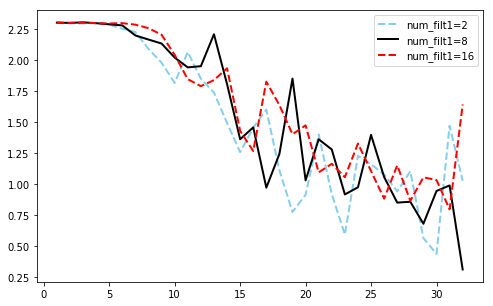

In [12]:
plt.figure(figsize=(8,5))
plt.plot(list(range(1,33)), cost_2a, color='skyblue', linewidth=2, linestyle='dashed', label='num_filt1=2')
plt.plot(list(range(1,33)), cost_1, color='black', linewidth=2, label='num_filt1=8')
plt.plot(list(range(1,33)), cost_2b, color='red', linewidth=2, linestyle='dashed', label='num_filt1=16')
plt.legend()
plt.show()

The difference between the decreasing cost values for each of the three networks trained does not appear to be very significant, despite some random errors. We do see, however, that both of the networks with adjusted `num_filt1` values have a higher resulting cost metric than the original network's. It also appears that the network with a decreased number of filters had a more steadily decreasing cost value.

## (3)

Change the number of channels for some layers, and show results.

The number of channels is represented by the variable `nf2`. It is the first dimension of the shape of the `pooled` object, which is the result of applying max-pooling to the second convolution operation. This result has dimensions `(n_c, h, w)`, where `n_c` is the first dimension of the inputted `image` parameter. When the `maxpool` function is used, the second convolution operation `conv2` is inputted as the image parameter, therefore the first dimension of `conv2` is used as the number of channels. This dimension is defined as the first dimension of `f2`, which is initialized with `num_filt2`. Therefore to change the number of channels, we need to vary `num_filt2`.

### Decrease number of channels

In [13]:
cost_3a = train(m=1000, batch_size=32, num_epochs=1, num_filt2=2)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32
Cost: 2.30 , Batch Num: 1
Cost: 2.30 , Batch Num: 2
Cost: 2.30 , Batch Num: 3
Cost: 2.30 , Batch Num: 4
Cost: 2.30 , Batch Num: 5
Cost: 2.28 , Batch Num: 6
Cost: 2.31 , Batch Num: 7
Cost: 2.27 , Batch Num: 8
Cost: 2.20 , Batch Num: 9
Cost: 2.09 , Batch Num: 10
Cost: 1.81 , Batch Num: 11
Cost: 2.08 , Batch Num: 12
Cost: 1.80 , Batch Num: 13
Cost: 1.48 , Batch Num: 14
Cost: 2.05 , Batch Num: 15
Cost: 1.84 , Batch Num: 16
Cost: 1.45 , Batch Num: 17
Cost: 1.53 , Batch Num: 18
Cost: 1.27 , Batch Num: 19
Cost: 1.71 , Batch Num: 20
Cost: 1.11 , Batch Num: 21
Cost: 1.15 , Batch Num: 22
Cost: 1.12 , Batch Num: 23
Cost: 1.22 , Batch Num: 24
Cost: 0.56 , Batch Num: 25
Cost: 1.26 , Batch Num: 26
Cost: 0.93 , Batch Num: 27
Cost: 0.72 , Batch Num: 28
Cost: 0.73 , Batch Num: 29
Cost: 0.66 , Batch Num: 30
Cost: 1.00 , Batch Num: 31
Cost: 0.61 , Batch Num: 32


### Increase number of channels

In [14]:
cost_3b = train(m=1000, batch_size=32, num_epochs=1, num_filt2=16)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
LR:0.01, Batch Size:32
Cost: 2.30 , Batch Num: 1
Cost: 2.30 , Batch Num: 2
Cost: 2.30 , Batch Num: 3
Cost: 2.30 , Batch Num: 4
Cost: 2.30 , Batch Num: 5
Cost: 2.28 , Batch Num: 6
Cost: 2.26 , Batch Num: 7
Cost: 2.22 , Batch Num: 8
Cost: 2.30 , Batch Num: 9
Cost: 2.23 , Batch Num: 10
Cost: 1.99 , Batch Num: 11
Cost: 1.64 , Batch Num: 12
Cost: 2.31 , Batch Num: 13
Cost: 1.76 , Batch Num: 14
Cost: 2.25 , Batch Num: 15
Cost: 1.68 , Batch Num: 16
Cost: 1.69 , Batch Num: 17
Cost: 1.99 , Batch Num: 18
Cost: 1.40 , Batch Num: 19
Cost: 1.19 , Batch Num: 20
Cost: 1.44 , Batch Num: 21
Cost: 1.35 , Batch Num: 22
Cost: 1.64 , Batch Num: 23
Cost: 1.12 , Batch Num: 24
Cost: 0.96 , Batch Num: 25
Cost: 0.90 , Batch Num: 26
Cost: 1.07 , Batch Num: 27
Cost: 1.06 , Batch Num: 28
Cost: 1.18 , Batch Num: 29
Cost: 0.85 , Batch Num: 30
Cost: 0.92 , Batch Num: 31
Cost: 0.43 , Batch Num: 32


### Results

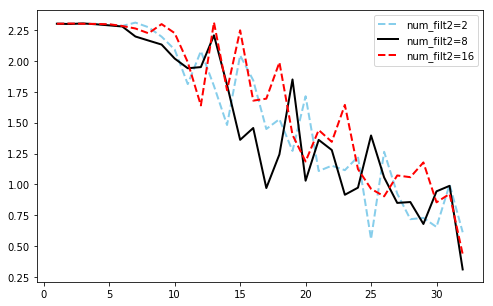

In [15]:
plt.figure(figsize=(8,5))
plt.plot(list(range(1,33)), cost_3a, color='skyblue', linewidth=2, linestyle='dashed', label='num_filt2=2')
plt.plot(list(range(1,33)), cost_1, color='black', linewidth=2, label='num_filt2=8')
plt.plot(list(range(1,33)), cost_3b, color='red', linewidth=2, linestyle='dashed', label='num_filt2=16')
plt.legend()
plt.show()

Something that stands out in this plot is the large amount of variation in the cost value for each batch when `num_filt2` is either increased or decreased. There are a few very high peaks and drops. However, towards the end of batch training, all three networks approach the same low cost value. However, the original network was still able to get the lowest cost value. This may point to the conclusion that more extreme numbers of channels lead to instability in training the network.

# Problem 2

https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

Read the above blog on RNN.

## (1)

Write a detailed annotation of the code.

In [2]:
# create the training and testing data
# create sine-wave-like data
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i + seq_len])
    Y.append(sin_wave[i + seq_len])

X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X_val = []
Y_val = []

# set aside 50 records as validation data
for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i + seq_len])
    Y_val.append(sin_wave[i + seq_len])

X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)


# define the activation function, sigmoid
# used in hidden layer
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
# step 2: train the model
# train until convergence, stop if overfit, or predefine number of epochs
def train(X, Y, learning_rate=0.0001, nepoch=25, T=50, hidden_dim=100, output_dim=1, bptt_truncate=5,
          min_clip_value=-10, max_clip_value=10):
    # define the weights of the network
    # U: matrix for weights between input and hidden layers
    # V: matrix for weights between hidden and output layers
    # W: matrix for shared weights in the RNN (hidden) layer
    U = np.random.uniform(0, 1, (hidden_dim, T))
    W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
    V = np.random.uniform(0, 1, (output_dim, hidden_dim))
    # step 2.1: check the loss on training data
    for epoch in range(nepoch):
        # check loss on train
        loss = 0.0

        # do a forward pass to get prediction
        for i in range(Y.shape[0]):
            # get input, output values of each record
            x, y = X[i], Y[i]
            # prev-s is the value of the previous activation of hidden layer
            # initialized as all zeroes
            prev_s = np.zeros((hidden_dim, 1))
            for t in range(T):
                # do a forward pass for every timestep in the sequence
                new_input = np.zeros(x.shape)
                # define a single input for that timestep
                new_input[t] = x[t]
                # multiply input by weights before hidden layers
                mulu = np.dot(U, new_input)
                # multiply prev activation by shared weights of RNN layer
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                # activation function
                s = sigmoid(add)
                # multiply activated s by weights before output
                mulv = np.dot(V, s)
                prev_s = s

            # calculate squared error to get the loss value
            loss_per_record = (y - mulv) ** 2 / 2
            loss += loss_per_record
        loss = loss / float(y.shape[0])

        # step 2.2: check the loss on validation data
        val_loss = 0.0
        # same algorithm
        for i in range(Y_val.shape[0]):
            x, y = X_val[i], Y_val[i]
            prev_s = np.zeros((hidden_dim, 1))
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                prev_s = s

            loss_per_record = (y - mulv) ** 2 / 2
            val_loss += loss_per_record
        val_loss = val_loss / float(y.shape[0])

        print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

        # step 2.3: start actual training
        # step 2.3.1: forward pass
        for i in range(Y.shape[0]):
            # initialization
            x, y = X[i], Y[i]

            layers = []
            prev_s = np.zeros((hidden_dim, 1))
            dU = np.zeros(U.shape)
            dV = np.zeros(V.shape)
            dW = np.zeros(W.shape)

            dU_t = np.zeros(U.shape)
            dW_t = np.zeros(W.shape)

            # forward pass
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                # multiply the input with the weights between the input and hidden layers
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                # add with the multiplication of weights in the RNN layer
                # captures knowledge of previous timestep
                add = mulw + mulu
                # pass through sigmoid activation function
                s = sigmoid(add)
                # multiply with weights btwn hidden and output layers
                mulv = np.dot(V, s)
                # save the current layer state and previous timestep state
                layers.append({'s': s, 'prev_s': prev_s})
                prev_s = s

            # derivative of pred
            dmulv = (mulv - y)

            # backward pass
            for t in range(T):
                # calculate the gradients at each layer
                dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
                dsv = np.dot(np.transpose(V), dmulv)

                ds = dsv
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)

                dprev_s = np.dot(np.transpose(W), dmulw)

                # truncated back propagation through time (TBPTT)
                for i in range(t - 1, max(-1, t - bptt_truncate - 1), -1):
                    ds = dsv + dprev_s
                    dadd = add * (1 - add) * ds

                    dmulw = dadd * np.ones_like(mulw)

                    dW_i = np.dot(W, layers[t]['prev_s'])
                    dprev_s = np.dot(np.transpose(W), dmulw)

                    new_input = np.zeros(x.shape)
                    new_input[t] = x[t]
                    dU_i = np.dot(U, new_input)

                    dU_t += dU_i
                    dW_t += dW_i

                dV += dV_t
                dU += dU_t
                dW += dW_t

                # update the weights with the gradients of weights calculated
                # clamp them in a range so that they don't explode
                if dU.max() > max_clip_value:
                    dU[dU > max_clip_value] = max_clip_value
                if dV.max() > max_clip_value:
                    dV[dV > max_clip_value] = max_clip_value
                if dW.max() > max_clip_value:
                    dW[dW > max_clip_value] = max_clip_value

                if dU.min() < min_clip_value:
                    dU[dU < min_clip_value] = min_clip_value
                if dV.min() < min_clip_value:
                    dV[dV < min_clip_value] = min_clip_value
                if dW.min() < min_clip_value:
                    dW[dW < min_clip_value] = min_clip_value

            # update
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW

    return U, V, W, hidden_dim, T

In [4]:
# run training to get weights
U, V, W, hidden_dim, T = train(X, Y)

Epoch:  1 , Loss:  [[123090.25748426]] , Val Loss:  [[61543.17530586]]
Epoch:  2 , Loss:  [[78478.70045612]] , Val Loss:  [[39237.78256585]]
Epoch:  3 , Loss:  [[43867.14342775]] , Val Loss:  [[21932.38982573]]
Epoch:  4 , Loss:  [[19255.58405135]] , Val Loss:  [[9626.9959115]]
Epoch:  5 , Loss:  [[4630.41333403]] , Val Loss:  [[2314.79922913]]
Epoch:  6 , Loss:  [[81.33166545]] , Val Loss:  [[40.56228642]]
Epoch:  7 , Loss:  [[29.05986778]] , Val Loss:  [[14.49940993]]
Epoch:  8 , Loss:  [[28.51958445]] , Val Loss:  [[14.22307817]]
Epoch:  9 , Loss:  [[28.31235163]] , Val Loss:  [[14.12703243]]
Epoch:  10 , Loss:  [[28.39576681]] , Val Loss:  [[14.16747065]]
Epoch:  11 , Loss:  [[28.56301609]] , Val Loss:  [[14.24783048]]
Epoch:  12 , Loss:  [[28.39246254]] , Val Loss:  [[14.16485141]]
Epoch:  13 , Loss:  [[28.15558046]] , Val Loss:  [[14.04387876]]
Epoch:  14 , Loss:  [[28.47615694]] , Val Loss:  [[14.20562586]]
Epoch:  15 , Loss:  [[28.3647941]] , Val Loss:  [[14.14867616]]
Epoch:  

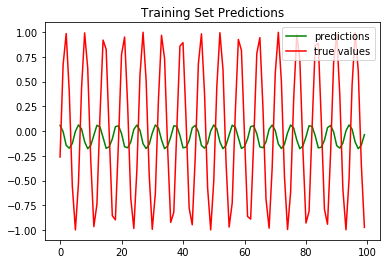

In [19]:
# step 3: get predictions
# training set predictions
preds_tr = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass through the trained weights
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds_tr.append(mulv)
    
preds_tr = np.array(preds_tr)

plt.plot(preds_tr[:, 0, 0], 'g', label='predictions')
plt.plot(Y[:, 0], 'r', label='true values')
plt.title('Training Set Predictions')
plt.legend()
plt.show()

The RNN surprisingly is not able to very accurately learn the training data. It is able to capture the periodicity of the sine wave, but the amplitude prediction is very low. This does not match what was shown in the original post, perhaps because of some random error.

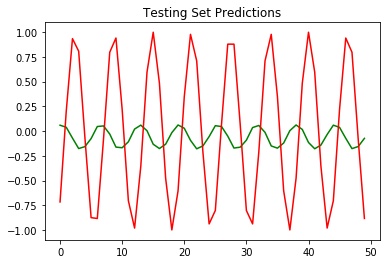

In [20]:
# testing set predictions
preds_ts = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds_ts.append(mulv)
    
preds_ts = np.array(preds_ts)

plt.plot(preds_ts[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.title('Testing Set Predictions')
plt.show()

When validated on the testing set, the original RNN simply replicates the pattern it predicted in the training data, where it is able to capture the periodicity of the sine wave but predicts a very low amplitude.

## (2)

Modify the data, e.g., using functions other than sine, and show results.

Let's try the triangle wave function, a periodic function. It is defined as $$\frac{4}{p}\Big(x-\frac{p}{2}\left \lceil{\frac{2x}{p}+\frac{1}{2}}\right \rceil \Big) (-1)^{\left \lceil{\frac{2x}{p}+\frac{1}{2}}\right \rceil}, $$ where $p$ is the period, $x$ is the argument, and ${\left \lceil{x}\right \rceil}$ is the floor function of $x$.

In [7]:
def triangle_wave(x, p=5):
    y = (4/p)*(x - (p/2)*np.floor((2*x/p) + (1/2)))*((-1)**np.floor((2*x/p) + (1/2)))
    return y

In [8]:
# create modified training and testing data
# create sqrt data
tri = np.array([triangle_wave(x) for x in np.arange(200)])

X_2 = []
Y_2 = []

seq_len = 50
num_records = len(tri) - seq_len

for i in range(num_records - 50):
    X_2.append(tri[i:i + seq_len])
    Y_2.append(tri[i + seq_len])

X_2 = np.array(X_2)
X_2 = np.expand_dims(X_2, axis=2)

Y_2 = np.array(Y_2)
Y_2 = np.expand_dims(Y_2, axis=1)

X_val_2 = []
Y_val_2 = []

# set aside 50 records as validation data
for i in range(num_records - 50, num_records):
    X_val_2.append(tri[i:i + seq_len])
    Y_val_2.append(tri[i + seq_len])

X_val_2 = np.array(X_val_2)
X_val_2 = np.expand_dims(X_val_2, axis=2)

Y_val_2 = np.array(Y_val_2)
Y_val_2 = np.expand_dims(Y_val_2, axis=1)

In [9]:
# run training to get weights
U_2, V_2, W_2, hidden_dim, T = train(X_2, Y_2)

Epoch:  1 , Loss:  [[123484.36331673]] , Val Loss:  [[61733.02579417]]
Epoch:  2 , Loss:  [[78791.63481109]] , Val Loss:  [[39389.39454048]]
Epoch:  3 , Loss:  [[44098.90630519]] , Val Loss:  [[22045.76328666]]
Epoch:  4 , Loss:  [[19406.17503138]] , Val Loss:  [[9702.13058685]]
Epoch:  5 , Loss:  [[4696.31197021]] , Val Loss:  [[2349.4784144]]
Epoch:  6 , Loss:  [[40.17930277]] , Val Loss:  [[26.45347878]]
Epoch:  7 , Loss:  [[16.24821469]] , Val Loss:  [[13.03732655]]
Epoch:  8 , Loss:  [[15.15317]] , Val Loss:  [[12.03242578]]
Epoch:  9 , Loss:  [[14.55133874]] , Val Loss:  [[11.59391587]]
Epoch:  10 , Loss:  [[14.28444673]] , Val Loss:  [[11.3013516]]
Epoch:  11 , Loss:  [[13.8060563]] , Val Loss:  [[10.9859561]]
Epoch:  12 , Loss:  [[13.08493221]] , Val Loss:  [[10.44440139]]
Epoch:  13 , Loss:  [[12.81370631]] , Val Loss:  [[10.16375487]]
Epoch:  14 , Loss:  [[12.49667994]] , Val Loss:  [[9.9727741]]
Epoch:  15 , Loss:  [[11.53159365]] , Val Loss:  [[9.24578488]]
Epoch:  16 , Los

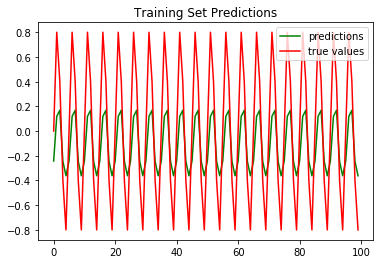

In [21]:
# step 3: get predictions
# training set predictions
preds_2_tr = []
for i in range(Y_2.shape[0]):
    x, y = X_2[i], Y_2[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass through the trained weights
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_2, new_input)
        mulw = np.dot(W_2, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_2, s)
        prev_s = s

    preds_2_tr.append(mulv)
    
preds_2_tr = np.array(preds_2_tr)

plt.plot(preds_2_tr[:, 0, 0], 'g', label='predictions')
plt.plot(Y_2[:, 0], 'r', label='true values')
plt.title('Training Set Predictions')
plt.legend()
plt.show()

This RNN shows similar behavior on the triangle wave as on the sine wave data. The period of the predictions looks accurate, but the height of the peaks are much lower than the true values.

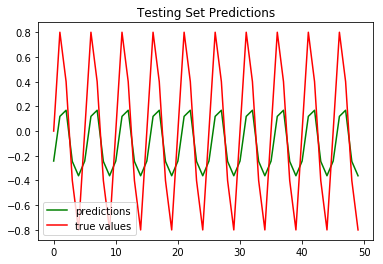

In [22]:
# testing set predictions
preds_2_ts = []
for i in range(Y_val_2.shape[0]):
    x, y = X_val_2[i], Y_val_2[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_2, new_input)
        mulw = np.dot(W_2, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_2, s)
        prev_s = s

    preds_2_ts.append(mulv)
    
preds_2_ts = np.array(preds_2_ts)

plt.plot(preds_2_ts[:, 0, 0], 'g', label='predictions')
plt.plot(Y_val_2[:, 0], 'r', label='true values')
plt.title('Testing Set Predictions')
plt.legend()
plt.show()

Once again, it seems like the RNN is able to capture the correct width of the period for each cycle of the triangle wave function, but for some reason it does not predict the right amplitude, with its predictions about half of the true values.

## (3)

Change the dimension of hidden vector, and show results.

We can use the `hidden_dim` parameter in the `train()` function to change the dimension of the hidden layer. The default value is 100, so let's experiment with decreasing and increasing the dimension. Also, we return to using the sine wave data rather than the triangle wave.

### Decrease the dimension of hidden vector

In [12]:
# run training to get weights
U_3a, V_3a, W_3a, hidden_dim_3a, T = train(X, Y, hidden_dim=50)

Epoch:  1 , Loss:  [[30541.48767507]] , Val Loss:  [[15269.75123618]]
Epoch:  2 , Loss:  [[19439.0456083]] , Val Loss:  [[9718.72308965]]
Epoch:  3 , Loss:  [[10836.50300165]] , Val Loss:  [[5417.64465786]]
Epoch:  4 , Loss:  [[4725.72307482]] , Val Loss:  [[2362.44647364]]
Epoch:  5 , Loss:  [[858.79068212]] , Val Loss:  [[429.16254621]]
Epoch:  6 , Loss:  [[37.34606023]] , Val Loss:  [[18.61518781]]
Epoch:  7 , Loss:  [[31.77019154]] , Val Loss:  [[15.84257681]]
Epoch:  8 , Loss:  [[31.56985495]] , Val Loss:  [[15.7473021]]
Epoch:  9 , Loss:  [[31.76705587]] , Val Loss:  [[15.84622721]]
Epoch:  10 , Loss:  [[31.79160893]] , Val Loss:  [[15.85915918]]
Epoch:  11 , Loss:  [[31.79645939]] , Val Loss:  [[15.86164563]]
Epoch:  12 , Loss:  [[31.90569887]] , Val Loss:  [[15.91572418]]
Epoch:  13 , Loss:  [[31.77990862]] , Val Loss:  [[15.85261037]]
Epoch:  14 , Loss:  [[31.87468933]] , Val Loss:  [[15.89932571]]
Epoch:  15 , Loss:  [[31.89856705]] , Val Loss:  [[15.91158718]]
Epoch:  16 , L

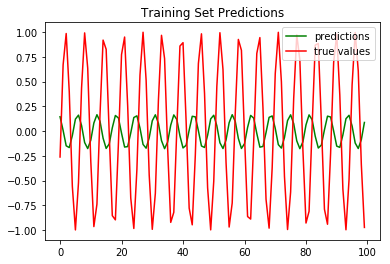

In [23]:
# step 3: get predictions
# training set predictions
preds_3a_tr = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim_3a, 1))
    # Forward pass through the trained weights
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_3a, new_input)
        mulw = np.dot(W_3a, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_3a, s)
        prev_s = s

    preds_3a_tr.append(mulv)
    
preds_3a_tr = np.array(preds_3a_tr)

plt.plot(preds_3a_tr[:, 0, 0], 'g', label='predictions')
plt.plot(Y[:, 0], 'r', label='true values')
plt.title('Training Set Predictions')
plt.legend()
plt.show()

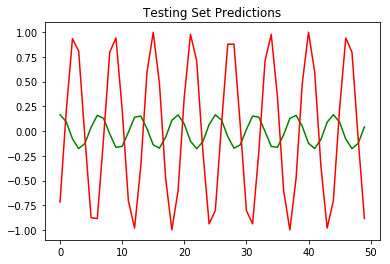

In [24]:
# testing set predictions
preds_3a_ts = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim_3a, 1))
    # For each time step...
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_3a, new_input)
        mulw = np.dot(W_3a, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_3a, s)
        prev_s = s

    preds_3a_ts.append(mulv)
    
preds_3a_ts = np.array(preds_3a_ts)

plt.plot(preds_3a_ts[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.title('Testing Set Predictions')
plt.show()

When the dimension of the hidden vector is decreased, it seems like it is not parameterized enough to fully capture the pattern in the data. However, it is not much different from the original network, despite a small increase in loss. It is able to recognize the cyclical behavior and replicate that, but the RNN does not accurately predict the amplitude of the cycles.

### Increase the dimension of hidden vector

In [15]:
# run training to get weights
U_3b, V_3b, W_3b, hidden_dim_3b, T = train(X, Y, hidden_dim=200)

Epoch:  1 , Loss:  [[508849.77954263]] , Val Loss:  [[254420.95858453]]
Epoch:  2 , Loss:  [[327092.52904666]] , Val Loss:  [[163543.10488467]]
Epoch:  3 , Loss:  [[185335.27855069]] , Val Loss:  [[92665.25118481]]
Epoch:  4 , Loss:  [[83578.02805471]] , Val Loss:  [[41787.39748494]]
Epoch:  5 , Loss:  [[21821.10427672]] , Val Loss:  [[10909.70742531]]
Epoch:  6 , Loss:  [[69.73320913]] , Val Loss:  [[34.76417683]]
Epoch:  7 , Loss:  [[45.98465247]] , Val Loss:  [[23.00546617]]
Epoch:  8 , Loss:  [[31.05576074]] , Val Loss:  [[15.42798289]]
Epoch:  9 , Loss:  [[30.31074816]] , Val Loss:  [[15.11021713]]
Epoch:  10 , Loss:  [[40.63877895]] , Val Loss:  [[20.33038641]]
Epoch:  11 , Loss:  [[36.36762798]] , Val Loss:  [[18.1680642]]
Epoch:  12 , Loss:  [[22.47453881]] , Val Loss:  [[11.16584207]]
Epoch:  13 , Loss:  [[29.12914418]] , Val Loss:  [[14.52976294]]
Epoch:  14 , Loss:  [[25.78139121]] , Val Loss:  [[12.88733476]]
Epoch:  15 , Loss:  [[44.0731282]] , Val Loss:  [[21.97007685]]
E

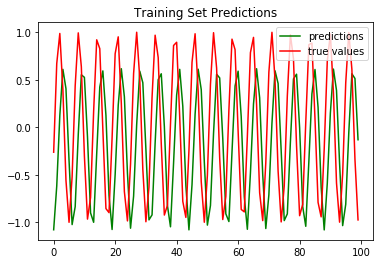

In [25]:
# step 3: get predictions
# training set predictions
preds_3b_tr = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim_3b, 1))
    # Forward pass through the trained weights
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_3b, new_input)
        mulw = np.dot(W_3b, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_3b, s)
        prev_s = s

    preds_3b_tr.append(mulv)
    
preds_3b_tr = np.array(preds_3b_tr)

plt.plot(preds_3b_tr[:, 0, 0], 'g', label='predictions')
plt.plot(Y[:, 0], 'r', label='true values')
plt.title('Training Set Predictions')
plt.legend()
plt.show()

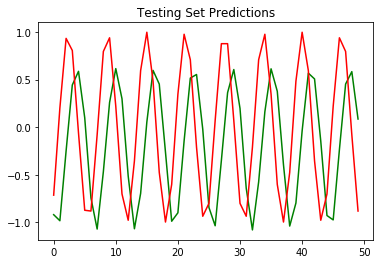

In [26]:
# testing set predictions
preds_3b_ts = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim_3b, 1))
    # For each time step...
    for t in range(T):
        # do a forward pass for every timestep in the sequence
        new_input = np.zeros(x.shape)
        # define a single input for that timestep
        new_input[t] = x[t]
        # multiply input by weights before hidden layers
        mulu = np.dot(U_3b, new_input)
        mulw = np.dot(W_3b, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V_3b, s)
        prev_s = s

    preds_3b_ts.append(mulv)
    
preds_3b_ts = np.array(preds_3b_ts)

plt.plot(preds_3b_ts[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.title('Testing Set Predictions')
plt.show()

Surprisingly, when the hidden vector dimension is doubled, the network does not overfit to the training data and is able to pretty accurately predict the sine wave values. This is the only network that has made some decent predictions on the sine wave data. The RNN with dimension 200 achieves a smaller validation loss than the network with dimension 100 towards the end of its training. Increasing the dimension of the hidden layers of the rest of the RNNs would likely increase their prediction accuracy.